In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import koreanize_matplotlib
from haversine import haversine

---
- 생활인구 데이터

In [4]:
# 생활인구 데이터 읽기
local_people = pd.read_csv('../mr_project/dong_local_people.csv', index_col=0)
local_people = local_people[local_people['시군구명'] == '강남구']
local_people = local_people[['행정동명', '총생활인구수']]
local_people['총생활인구수'] = local_people['총생활인구수'].round(0)

In [5]:
pivot_local = local_people.pivot_table(index=['행정동명'], values='총생활인구수', aggfunc='sum')
pivot_local['일생활인구수'] = (pivot_local['총생활인구수'] / 30).round(0)

In [6]:
dong_local_people = pivot_local.reset_index()
dong_local_people.rename(columns={'총생활인구수':'월생활인구수'}, inplace=True)
dong_local_people

,행정동명,월생활인구수,일생활인구수
0,개포1동,6077626.0,202588.0
1,개포2동,23387518.0,779584.0
2,개포4동,11298748.0,376625.0
3,논현1동,31058973.0,1035299.0
4,논현2동,33406941.0,1113565.0
5,대치1동,21221259.0,707375.0
6,대치2동,36250572.0,1208352.0
7,대치4동,28811042.0,960368.0
8,도곡1동,25885996.0,862867.0
9,도곡2동,21529572.0,717652.0


In [7]:
# 행정동명 통합하기
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['개포1동', '개포2동', '개포4동'], '개포동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['논현1동', '논현2동'], '논현동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['대치1동', '대치2동', '대치4동'], '대치동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['도곡1동', '도곡2동'], '도곡동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['삼성1동', '삼성2동'], '삼성동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['역삼1동', '역삼2동'], '역삼동')
dong_local_people['행정동명'] = dong_local_people['행정동명'].replace(['일원1동', '일원2동', '일원본동'], '일원동')

dong_local_people = dong_local_people.groupby(['행정동명']).sum().reset_index()
dong_local_people

,행정동명,월생활인구수,일생활인구수
0,개포동,40763892.0,1358797.0
1,논현동,64465914.0,2148864.0
2,대치동,86282873.0,2876095.0
3,도곡동,47415568.0,1580519.0
4,삼성동,58399537.0,1946651.0
5,세곡동,32624060.0,1087469.0
6,수서동,16457392.0,548580.0
7,신사동,26460904.0,882030.0
8,압구정동,31107504.0,1036917.0
9,역삼동,117012100.0,3900403.0


In [8]:
# 생활인구 데이터 단위 축소 (10만명 기준)
dong_local_people['월생활인구수'] = dong_local_people['월생활인구수'] / 100000
dong_local_people['일생활인구수'] = dong_local_people['일생활인구수'] / 100000

In [9]:
dong_local_people

,행정동명,월생활인구수,일생활인구수
0,개포동,407.63892,13.58797
1,논현동,644.65914,21.48864
2,대치동,862.82873,28.76095
3,도곡동,474.15568,15.80519
4,삼성동,583.99537,19.46651
5,세곡동,326.24060,10.87469
6,수서동,164.57392,5.48580
7,신사동,264.60904,8.82030
8,압구정동,311.07504,10.36917
9,역삼동,1170.12100,39.00403


---
- 편의시설 데이터

In [10]:
# 편의시설 데이터 읽기
convenience = pd.read_csv('../mr_project/convenience store.csv', index_col=0)
restroom = pd.read_csv('../mr_project/gn_restroom.csv', index_col=0)
sports = pd.read_csv('../mr_project/ARR_SPORTS.csv', index_col=0)
tour = pd.read_csv('../mr_project/ARR_TOURISM.csv', index_col=0)
food = pd.read_csv('../mr_project/ARR_FOOD.csv', index_col=0)
culture = pd.read_csv('../mr_project/ARR_CULTURE.CSV', index_col=0)
subway = pd.read_csv('../mr_project/강남구지하철.csv', index_col=0)
subway.columns = ['subway_name', 'line', 'address', 'dong', 'lat', 'lng']

In [11]:
# 편의시설 개수 계산
convenience_counts = convenience.groupby('dong').size().reset_index(name='convenience_count')
restroom_counts = restroom.groupby('dong').size().reset_index(name='restroom_count')
sports_counts = sports.groupby('dong').size().reset_index(name='sports_count')
tour_counts = tour.groupby('dong').size().reset_index(name='tour_count')
food_counts = food.groupby('dong').size().reset_index(name='food_count')
culture_counts = culture.groupby('dong').size().reset_index(name='culture_count')
subway_counts = subway.groupby('dong').size().reset_index(name='subway_count')

In [12]:
food_counts

,dong,food_count
0,개포,270
1,논현,2045
2,대치,1152
3,도곡,368
4,삼성,972
5,세곡,63
6,수서,123
7,신사,1548
8,압구,94
9,역삼,2694


In [13]:
# food_counts columns 재정립
new_columns={'dong' : 'dong_s'}
food_counts.rename(columns=new_columns, inplace=True)

food_counts['dong'] = np.nan
food_counts['dong'] = food_counts['dong_s'] + '동'

food_counts['dong'].replace('압구동', '압구정동', inplace=True)

food_counts

,dong_s,food_count,dong
0,개포,270,개포동
1,논현,2045,논현동
2,대치,1152,대치동
3,도곡,368,도곡동
4,삼성,972,삼성동
5,세곡,63,세곡동
6,수서,123,수서동
7,신사,1548,신사동
8,압구,94,압구정동
9,역삼,2694,역삼동


In [14]:
# restroom_counts columns 재정립
new_columns={'dong' : 'dong_s'}
restroom_counts.rename(columns=new_columns, inplace=True)

restroom_counts['dong'] = 0
restroom_counts['dong'] = restroom_counts['dong_s'] + '동'

restroom_counts['dong'].replace('압구동', '압구정동', inplace=True)

restroom_counts

,dong_s,restroom_count,dong
0,개포,26,개포동
1,논현,20,논현동
2,대치,23,대치동
3,도곡,16,도곡동
4,삼성,27,삼성동
5,세곡,5,세곡동
6,수서,9,수서동
7,신사,13,신사동
8,압구,10,압구정동
9,양재,2,양재동


In [15]:
# convenience_counts: '율현동'과 '자곡동'의 값을 '세곡동'으로 대체
convenience_counts['dong'].replace(['율현동', '자곡동'], '세곡동', inplace=True)
convenience_counts = convenience_counts.groupby('dong')['convenience_count'].sum().reset_index()

convenience_counts


,dong,convenience_count
0,개포동,39
1,논현동,121
2,대치동,99
3,도곡동,38
4,삼성동,88
5,세곡동,25
6,수서동,15
7,신사동,66
8,압구정동,8
9,역삼동,203


In [16]:
# food_counts: '율현동'과 '자곡동'의 값을 '세곡동'으로 대체
food_counts['dong'].replace(['율현동', '자곡동'], '세곡동', inplace=True)
food_counts = food_counts.groupby('dong')['food_count'].sum().reset_index()

food_counts

,dong,food_count
0,개포동,270
1,논현동,2045
2,대치동,1152
3,도곡동,368
4,삼성동,972
5,세곡동,97
6,수서동,123
7,신사동,1548
8,압구정동,94
9,역삼동,2694


In [17]:
# restroom_counts: '율현동'과 '자곡동'의 값을 '세곡동'으로 대체
restroom_counts['dong'].replace(['율현동', '자곡동'], '세곡동', inplace=True)
restroom_counts = restroom_counts.groupby('dong')['restroom_count'].sum().reset_index()

restroom_counts

,dong,restroom_count
0,개포동,26
1,논현동,20
2,대치동,23
3,도곡동,16
4,삼성동,27
5,세곡동,8
6,수서동,9
7,신사동,13
8,압구정동,10
9,양재동,2


- 개수 일원화 완료 : 생활인구 개수 기준
---

- 생활인구와 편의시설 병합

In [47]:
# 생활인구 데이터와 편의시설 개수 데이터 병합
dong_local_counts = pd.merge(dong_local_people, convenience_counts, how='left', left_on='행정동명', right_on='dong')
dong_local_counts = pd.merge(dong_local_counts, restroom_counts, how='left')
dong_local_counts = pd.merge(dong_local_counts, sports_counts, how='left')
dong_local_counts = pd.merge(dong_local_counts, tour_counts, how='left')
dong_local_counts = pd.merge(dong_local_counts, food_counts, how='left')
dong_local_counts = pd.merge(dong_local_counts, culture_counts, how='left')
dong_local_counts = pd.merge(dong_local_counts, subway_counts, how='left')

# nan 값 채우기 (tour/culture/subway = 0)
dong_local_counts.fillna({'tour_count' : 0,
                          'culture_count' : 0,
                          'subway_count' : 0}, inplace=True)

In [48]:
dong_local_counts

,행정동명,월생활인구수,일생활인구수,dong,convenience_count,restroom_count,sports_count,tour_count,food_count,culture_count,subway_count
0,개포동,407.63892,13.58797,개포동,39,26,69,5.0,270,1.0,0.0
1,논현동,644.65914,21.48864,논현동,121,20,172,44.0,2045,12.0,3.0
2,대치동,862.82873,28.76095,대치동,99,23,161,15.0,1152,4.0,2.0
3,도곡동,474.15568,15.80519,도곡동,38,16,71,1.0,368,2.0,2.0
4,삼성동,583.99537,19.46651,삼성동,88,27,106,39.0,972,6.0,6.0
5,세곡동,326.24060,10.87469,세곡동,25,8,10,0.0,97,0.0,0.0
6,수서동,164.57392,5.48580,수서동,15,9,23,0.0,123,0.0,1.0
7,신사동,264.60904,8.82030,신사동,66,13,117,30.0,1548,10.0,2.0
8,압구정동,311.07504,10.36917,압구정동,8,10,11,0.0,94,0.0,0.0
9,역삼동,1170.12100,39.00403,역삼동,203,29,252,97.0,2694,7.0,2.0


In [49]:
dong_local_counts.to_csv("dong_local_counts.csv", encoding='utf-8')

In [51]:
# 월생활인구로 나눠보기
convenience_month = dong_local_counts['convenience_count'].divide(dong_local_counts['월생활인구수'])
restroom_month = dong_local_counts['restroom_count'].divide(dong_local_counts['월생활인구수'])
sports_month = dong_local_counts['sports_count'].divide(dong_local_counts['월생활인구수'])
tour_month = dong_local_counts['tour_count'].divide(dong_local_counts['월생활인구수'])
food_month = dong_local_counts['food_count'].divide(dong_local_counts['월생활인구수'])
culture_month = dong_local_counts['culture_count'].divide(dong_local_counts['월생활인구수'])
subway_month = dong_local_counts['subway_count'].divide(dong_local_counts['월생활인구수'])


popluation_month = pd.DataFrame({'convenience_month': convenience_month,
                                 'restroom_month' : restroom_month,
                                 'sports_month' : sports_month,
                                 'tour_month' : tour_month,
                                 'food_month' : food_month,
                                 'culture_month' : culture_month,
                                 'subway_month' : subway_month
                                 })

popluation_month = popluation_month.set_index(dong_local_counts['행정동명']).reset_index()

# nan 값 채우기 (tour/culture/subway = 0)
popluation_month.fillna({'tour_month' : 0,
                          'culture_month' : 0,
                          'subway_month' : 0}, inplace=True)
popluation_month

,행정동명,convenience_month,restroom_month,sports_month,tour_month,food_month,culture_month,subway_month
0,개포동,0.095673,0.063782,0.169267,0.012266,0.662351,0.002453,0.000000
1,논현동,0.187696,0.031024,0.266808,0.068253,3.172219,0.018614,0.004654
2,대치동,0.114739,0.026657,0.186596,0.017385,1.335143,0.004636,0.002318
3,도곡동,0.080142,0.033744,0.149740,0.002109,0.776116,0.004218,0.004218
4,삼성동,0.150686,0.046233,0.181508,0.066781,1.664397,0.010274,0.010274
5,세곡동,0.076631,0.024522,0.030652,0.000000,0.297327,0.000000,0.000000
6,수서동,0.091144,0.054687,0.139755,0.000000,0.747385,0.000000,0.006076
7,신사동,0.249425,0.049129,0.442162,0.113375,5.850140,0.037792,0.007558
8,압구정동,0.025717,0.032147,0.035361,0.000000,0.302178,0.000000,0.000000
9,역삼동,0.173486,0.024784,0.215362,0.082897,2.302326,0.005982,0.001709


---
- 시각화 


In [52]:
dong_local_counts

,행정동명,월생활인구수,일생활인구수,dong,convenience_count,restroom_count,sports_count,tour_count,food_count,culture_count,subway_count
0,개포동,407.63892,13.58797,개포동,39,26,69,5.0,270,1.0,0.0
1,논현동,644.65914,21.48864,논현동,121,20,172,44.0,2045,12.0,3.0
2,대치동,862.82873,28.76095,대치동,99,23,161,15.0,1152,4.0,2.0
3,도곡동,474.15568,15.80519,도곡동,38,16,71,1.0,368,2.0,2.0
4,삼성동,583.99537,19.46651,삼성동,88,27,106,39.0,972,6.0,6.0
5,세곡동,326.24060,10.87469,세곡동,25,8,10,0.0,97,0.0,0.0
6,수서동,164.57392,5.48580,수서동,15,9,23,0.0,123,0.0,1.0
7,신사동,264.60904,8.82030,신사동,66,13,117,30.0,1548,10.0,2.0
8,압구정동,311.07504,10.36917,압구정동,8,10,11,0.0,94,0.0,0.0
9,역삼동,1170.12100,39.00403,역삼동,203,29,252,97.0,2694,7.0,2.0


In [66]:
popluation_month

,행정동명,convenience_month,restroom_month,sports_month,tour_month,food_month,culture_month,subway_month
0,개포동,0.095673,0.063782,0.169267,0.012266,0.662351,0.002453,0.000000
1,논현동,0.187696,0.031024,0.266808,0.068253,3.172219,0.018614,0.004654
2,대치동,0.114739,0.026657,0.186596,0.017385,1.335143,0.004636,0.002318
3,도곡동,0.080142,0.033744,0.149740,0.002109,0.776116,0.004218,0.004218
4,삼성동,0.150686,0.046233,0.181508,0.066781,1.664397,0.010274,0.010274
5,세곡동,0.076631,0.024522,0.030652,0.000000,0.297327,0.000000,0.000000
6,수서동,0.091144,0.054687,0.139755,0.000000,0.747385,0.000000,0.006076
7,신사동,0.249425,0.049129,0.442162,0.113375,5.850140,0.037792,0.007558
8,압구정동,0.025717,0.032147,0.035361,0.000000,0.302178,0.000000,0.000000
9,역삼동,0.173486,0.024784,0.215362,0.082897,2.302326,0.005982,0.001709


In [67]:
pop = popluation_month 

In [78]:
barplot = popluation_month.melt('행정동명', ['convenience_month', 'restroom_month', 'sports_month', 'tour_month', 'food_month', 'culture_month', 'subway_month'])

bar_plot1 = pop.melt('행정동명', 'food_month')
bar_plot2 = pop.melt('행정동명', ['culture_month', 'subway_month'])
bar_plot3 = pop.melt('행정동명', ['convenience_month', 'restroom_month', 'sports_month', 'tour_month'])


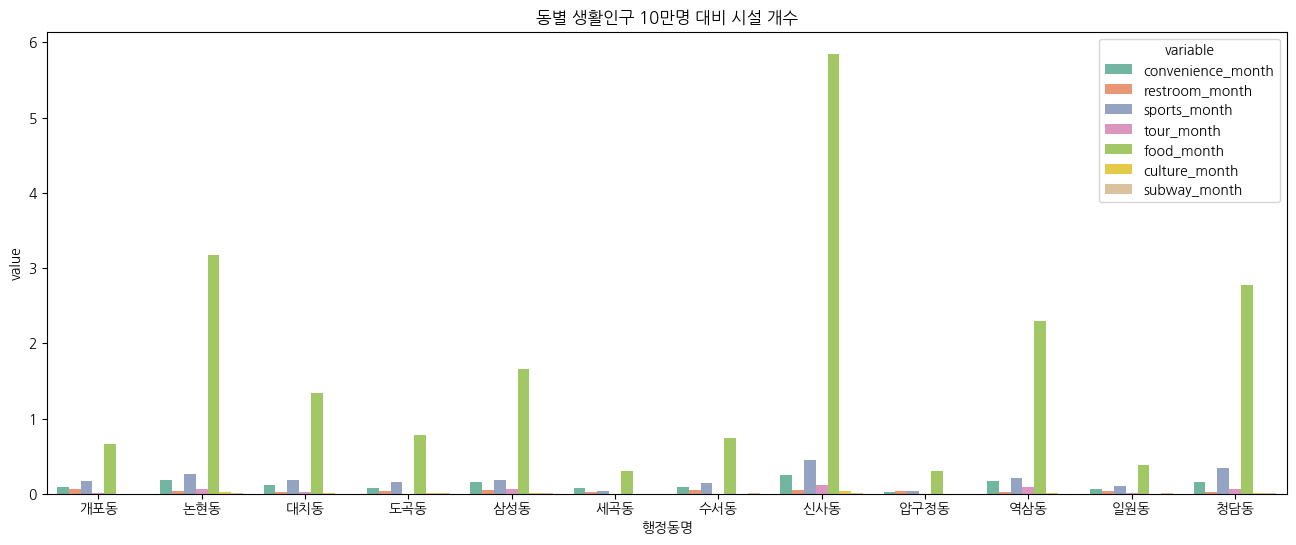

In [80]:
plt.figure(figsize=(16, 6))
sns.barplot(data=barplot, x='행정동명', y='value', hue='variable', palette='Set2', lw=2)

plt.title('동별 생활인구 10만명 대비 시설 개수')
plt.show()

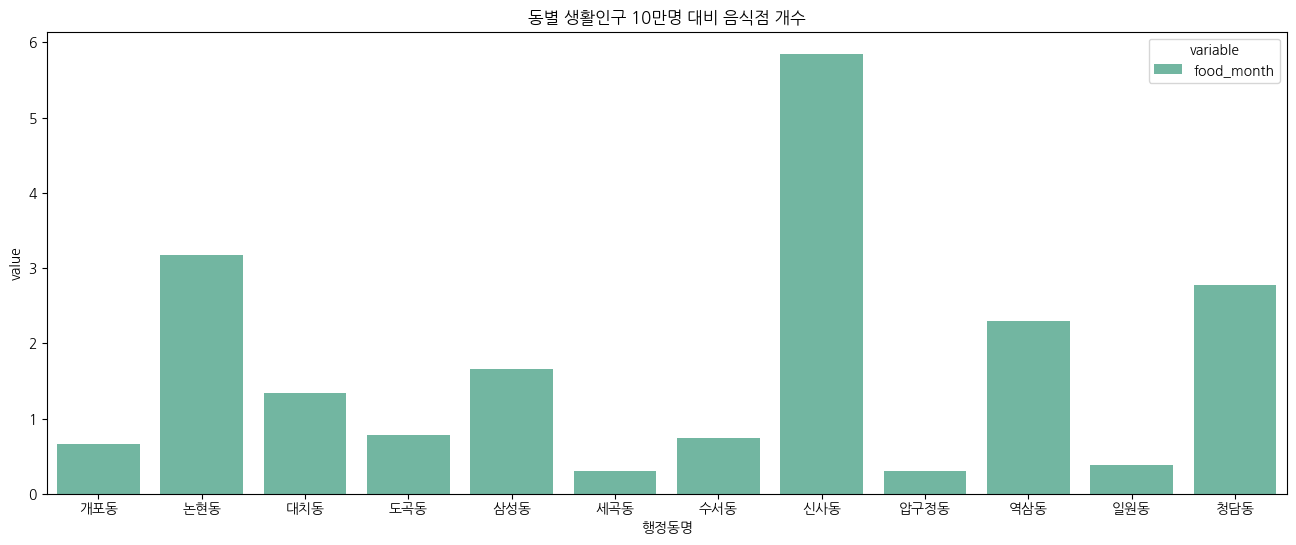

In [75]:
plt.figure(figsize=(16, 6))
sns.barplot(data=bar_plot1, x='행정동명', y='value', hue='variable', palette='Set2', lw=2)

plt.title('동별 생활인구 10만명 대비 음식점 개수')
plt.show()

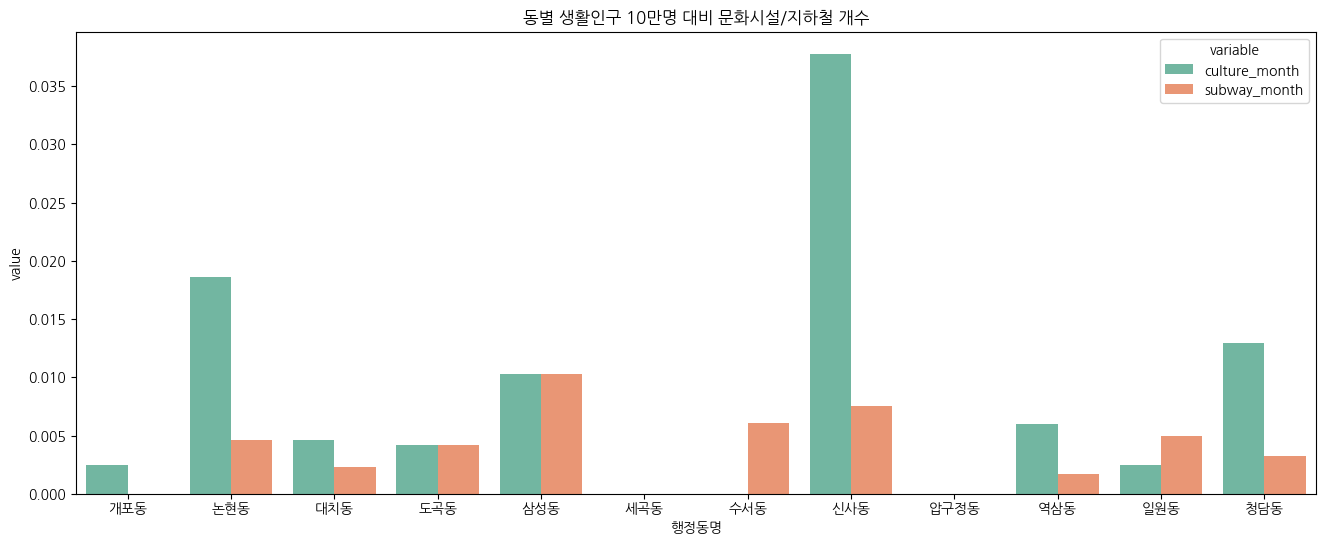

In [83]:
plt.figure(figsize=(16, 6))
sns.barplot(data=bar_plot2, x='행정동명', y='value', hue='variable', palette='Set2', lw=2)
plt.title('동별 생활인구 10만명 대비 문화시설/지하철 개수')
plt.show()

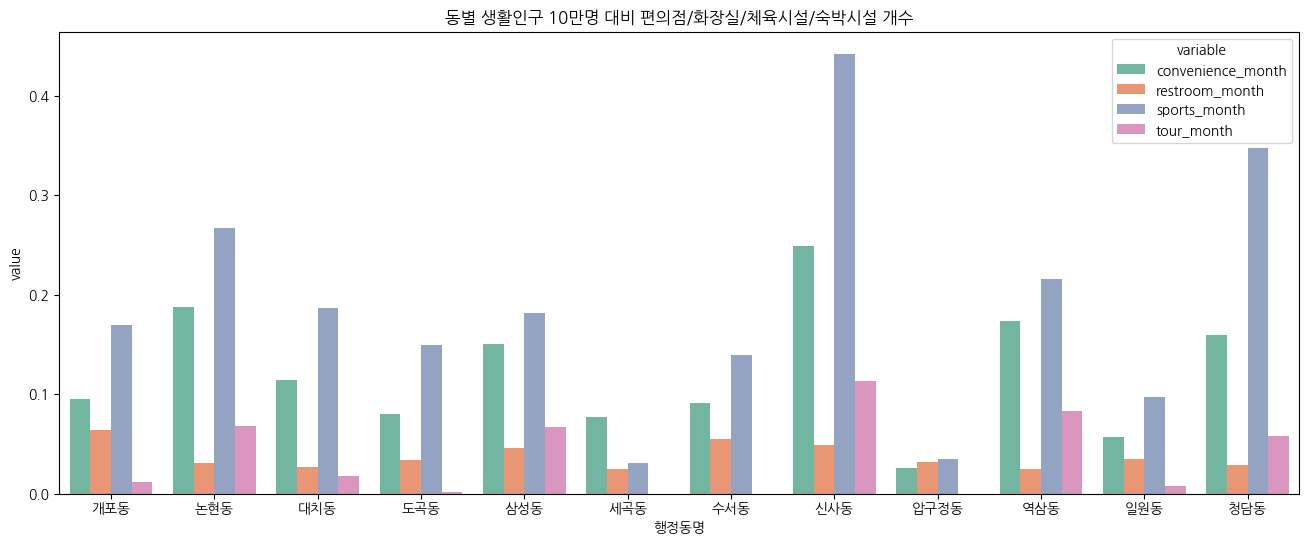

In [85]:
plt.figure(figsize=(16, 6))
sns.barplot(data=bar_plot3, x='행정동명', y='value', hue='variable', palette='Set2', lw=2)
plt.title('동별 생활인구 10만명 대비 편의점/화장실/체육시설/숙박시설 개수')
plt.show()